<a href="https://colab.research.google.com/github/Kim-matthew-0422/airbnb-trends-nlp/blob/main/airbnbseattle(incomplete).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-680e6bc8-caed-bdcf-b673-41bf787d9779)


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"etkim422","key":"80ab2ded6fd7d42e4f1a1492a557fa36"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d airbnb/seattle

 92% 18.0M/19.5M [00:01<00:00, 19.6MB/s]
100% 19.5M/19.5M [00:01<00:00, 11.3MB/s]


In [ ]:
!ls

kaggle.json  sample_data  seattle.zip


In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

--2023-03-21 08:14:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-21 08:14:05 (97.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
unzip_data('seattle.zip')

In [ ]:
!ls

calendar.csv	     kaggle.json   __pycache__	sample_data
helper_functions.py  listings.csv  reviews.csv	seattle.zip


BadZipFile: ignored

In [ ]:
!ls

helper_functions.py	     sample_submission_2.csv.zip
kaggle.json		     train_1.csv
key_1.csv.zip		     train_1.csv.zip
key_2.csv.zip		     train_2.csv
__pycache__		     train_2.csv.zip
sample_data		     web-traffic-time-series-forecasting.zip
sample_submission_1.csv.zip


In [7]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"


In [9]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 24.7 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=6f3eca0a33fd2858cf482d96f27d4e0284f8f184f48cf7540de0445b6fca2ccb
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [10]:
import pyspark
import pandas as pd
import numpy as np

In [11]:
from pyspark.sql import SparkSession


In [12]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz


In [13]:
!tar xf spark-3.3.2-bin-hadoop3.tgz


In [14]:
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Test Setup")\
        .getOrCreate()

In [ ]:
!ls

calendar.csv	     __pycache__  spark-3.3.2-bin-hadoop3
helper_functions.py  reviews.csv  spark-3.3.2-bin-hadoop3.tgz
kaggle.json	     sample_data
listings.csv	     seattle.zip


In [15]:
listings = spark.read.option('inferSchema', 'true').csv('listings.csv', header = True).coalesce(1)
calendar = spark.read.option('inferSchema', 'true').csv('calendar.csv', header = True).repartition(8)


In [16]:
reviews = spark.read.option('inferSchema', 'true').csv('reviews.csv', header = True).repartition(2)

In [17]:
reviews.test = spark.read.csv('reviews.csv',header = True)

In [18]:
reviews.test.show()

+--------------------+--------------------+-----------------+-----------+-------------+--------------------+
|          listing_id|                  id|             date|reviewer_id|reviewer_name|            comments|
+--------------------+--------------------+-----------------+-----------+-------------+--------------------+
|             7202016|            38917982|       2015-07-19|   28943674|       Bianca|Cute and cozy pla...|
|             7202016|            39087409|       2015-07-20|   32440555|        Frank|Kelly has a great...|
| Beautiful building | architecture and...|             null|       null|         null|                null|
|We felt guite at ...|                null|             null|       null|         null|                null|
|Went for a walk a...|                null|             null|       null|         null|                null|
|Visited the Space...|                null|             null|       null|         null|                null|
|             72020

In [19]:
df = reviews

In [20]:
from pyspark.sql.functions import when, col

df = df.withColumn('comments_string', when(col('listing_id').rlike("[a-zA-Z]"), col('listing_id')).otherwise(None))

In [21]:
from pyspark.sql.functions import col, concat_ws, when

df = df.withColumn(
    "comments_string",
    concat_ws("", col("comments_string"), when(col("id").rlike("[a-zA-Z]"), col("id")).otherwise(None))
)

In [22]:
df = df.withColumn(
    "comments_string",
    concat_ws("", col("comments_string"), when(col("date").rlike("[a-zA-Z]"), col("date")).otherwise(None))
)

In [23]:
df.show()

+--------------------+--------------------+--------------------+-----------+-------------+--------------------+--------------------+
|          listing_id|                  id|                date|reviewer_id|reviewer_name|            comments|     comments_string|
+--------------------+--------------------+--------------------+-----------+-------------+--------------------+--------------------+
|             2026794|            34759218|          2015-06-11|   35407951|       Scotty|Sheryl greeted me...|                    |
|We were very worr...|                null|                null|       null|         null|                null|We were very worr...|
|              387464|            38710154|          2015-07-18|    6309928|        Helen|This was our seco...|                    |
|             6389657|            39314524|          2015-07-22|    1852794|         Anna|I had a long layo...|                    |
|The room and rest...|                null|                null|     

In [ ]:
df.take(16)[14]

Row(listing_id='Both Roberta and Dan take obvious and well-deserved pride in this property. All of the little details - from the thoughtful addition of rope lighting along the meandering path down to the cabin', id=' to the welcoming bowl of fruit', date=' to our choice of cozy flannel sheets or crisp cotton ones on that insanely comfortable bed - have been carefully thought out and executed to make staying at this lovely cabin the best possible experience.', reviewer_id=None, reviewer_name=None, comments=None, comments_string='Both Roberta and Dan take obvious and well-deserved pride in this property. All of the little details - from the thoughtful addition of rope lighting along the meandering path down to the cabin  to the welcoming bowl of fruit to our choice of cozy flannel sheets or crisp cotton ones on that insanely comfortable bed - have been carefully thought out and executed to make staying at this lovely cabin the best possible experience.')

okay, I have no idea what's happening with reviews, but it seems like there is no correlation with listing_ids that have comments in them and the above listing_id. for example, Roberta and Dan is not the same person as the listing_id 1707064 even though it should be logically, when their name is Cory and Amanda. so, I'm just gonna drop em!

In [24]:
listings.count()

7868

In [25]:
calendar.count()

1393570

In [26]:
reviews.count()

125742

In [27]:
reviews = reviews.filter(col("listing_id").cast("int").isNotNull())

In [ ]:
reviews.show()

+----------+--------+----------+-----------+-------------+--------------------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|
+----------+--------+----------+-----------+-------------+--------------------+
|    176678| 5042747|2013-06-09|    6585682|        Jakob|Staying with Laur...|
|   6389657|39314524|2015-07-22|    1852794|         Anna|I had a long layo...|
|   3308825|40130369|2015-07-28|   13615443|     Kathleen|We had a wonderfu...|
|   1618842|51261474|2015-10-19|     349348|         Jean|The studio is eve...|
|    935845|13512921|2014-05-29|   14860397|        Clint|Wendy's apartment...|
|    797358|31500559|2015-05-05|     229056|          Dee|Awesome house! Gr...|
|     63733| 1983283|2012-08-14|    2432638|        Carla|Very cute, cozy p...|
|   1707064|18497790|2014-08-27|   19956826|         Erin|Cory and Amanda w...|
|    158345| 4067973|2013-04-07|    5591022|       Mariah|Marcia is the bes...|
|   1539476|52340775|2015-10-28|   11966

In [ ]:
calendar.show()

+----------+-------------------+---------+-------+
|listing_id|               date|available|  price|
+----------+-------------------+---------+-------+
|   3959442|2016-09-01 00:00:00|        t|$150.00|
|   6425735|2017-01-01 00:00:00|        t| $99.00|
|   6426462|2016-11-13 00:00:00|        t| $65.00|
|   8104742|2016-02-04 00:00:00|        t|$200.00|
|   5969872|2016-03-19 00:00:00|        t| $43.00|
|    654734|2016-12-12 00:00:00|        t|$175.00|
|   1566487|2016-01-05 00:00:00|        t| $79.00|
|   7401854|2016-10-19 00:00:00|        t| $95.00|
|   9318440|2016-11-05 00:00:00|        t|$200.00|
|    815017|2016-09-02 00:00:00|        t| $75.00|
|   7440415|2016-03-16 00:00:00|        t|$180.00|
|   8814555|2016-12-11 00:00:00|        t| $88.00|
|    936484|2016-07-24 00:00:00|        t|$309.00|
|    240920|2016-12-19 00:00:00|        t| $45.00|
|   7035240|2016-08-15 00:00:00|        t|$300.00|
|   6916167|2016-11-28 00:00:00|        t|$300.00|
|   4053092|2016-03-04 00:00:00

In [ ]:
reviews.show()

+--------------------+--------------------+--------------------+-----------+-------------+--------------------+
|          listing_id|                  id|                date|reviewer_id|reviewer_name|            comments|
+--------------------+--------------------+--------------------+-----------+-------------+--------------------+
|             2026794|            34759218|          2015-06-11|   35407951|       Scotty|Sheryl greeted me...|
|We were very worr...|                null|                null|       null|         null|                null|
|              387464|            38710154|          2015-07-18|    6309928|        Helen|This was our seco...|
|             6389657|            39314524|          2015-07-22|    1852794|         Anna|I had a long layo...|
|The room and rest...|                null|                null|       null|         null|                null|
|The rooms are clo...| so it is ideal t...|                null|       null|         null|              

In [28]:
listings.show()
from pyspark.sql.functions import regexp_replace

calendar = calendar.withColumn("price", regexp_replace(col("price"), "[$,]", "").cast("float"))


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+--------------------+----------------------+----------------------------+--------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+------------------+--------------------+-

In [ ]:
calendar.show()

+----------+-------------------+---------+-----+
|listing_id|               date|available|price|
+----------+-------------------+---------+-----+
|   3959442|2016-09-01 00:00:00|        t|150.0|
|   6425735|2017-01-01 00:00:00|        t| 99.0|
|   6426462|2016-11-13 00:00:00|        t| 65.0|
|   8104742|2016-02-04 00:00:00|        t|200.0|
|   5969872|2016-03-19 00:00:00|        t| 43.0|
|    654734|2016-12-12 00:00:00|        t|175.0|
|   1566487|2016-01-05 00:00:00|        t| 79.0|
|   7401854|2016-10-19 00:00:00|        t| 95.0|
|   9318440|2016-11-05 00:00:00|        t|200.0|
|    815017|2016-09-02 00:00:00|        t| 75.0|
|   7440415|2016-03-16 00:00:00|        t|180.0|
|   8814555|2016-12-11 00:00:00|        t| 88.0|
|    936484|2016-07-24 00:00:00|        t|309.0|
|    240920|2016-12-19 00:00:00|        t| 45.0|
|   7035240|2016-08-15 00:00:00|        t|300.0|
|   6916167|2016-11-28 00:00:00|        t|300.0|
|   4053092|2016-03-04 00:00:00|        t| 80.0|
|   8293287|2016-09-

In [29]:
from pyspark.sql.functions import col, avg

available_df = calendar.filter(col('available') == 't')

In [ ]:
available_df.show()

+----------+-------------------+---------+-----+
|listing_id|               date|available|price|
+----------+-------------------+---------+-----+
|   3959442|2016-09-01 00:00:00|        t|150.0|
|   3385421|2016-12-09 00:00:00|        t|557.0|
|   1114695|2016-02-16 00:00:00|        t|200.0|
|   7763298|2016-07-19 00:00:00|        t| 80.0|
|   6490091|2016-02-16 00:00:00|        t| 95.0|
|   4948745|2016-11-09 00:00:00|        t| 90.0|
|   8187537|2016-02-05 00:00:00|        t|121.0|
|     80188|2016-09-23 00:00:00|        t|114.0|
|    692080|2016-07-03 00:00:00|        t|370.0|
|   4639465|2016-03-19 00:00:00|        t|129.0|
|   4532538|2016-07-29 00:00:00|        t|180.0|
|   1428687|2016-08-11 00:00:00|        t|160.0|
|   8939736|2016-05-16 00:00:00|        t| 41.0|
|   5524847|2016-02-13 00:00:00|        t|118.0|
|   9574602|2016-07-19 00:00:00|        t|150.0|
|   3652434|2016-03-17 00:00:00|        t| 95.0|
|   3354761|2016-03-18 00:00:00|        t|125.0|
|   3639023|2016-01-

root
 |-- listing_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- available: string (nullable = true)
 |-- price: string (nullable = true)



In [30]:
price_trends_df = available_df.groupby('date').agg(avg('price').alias('avg_price')).orderBy('date')

In [31]:
price_trends_df.show()

+-------------------+------------------+
|               date|         avg_price|
+-------------------+------------------+
|2016-01-04 00:00:00|122.08587896253603|
|2016-01-05 00:00:00|120.68130690948045|
|2016-01-06 00:00:00|120.92825848849945|
|2016-01-07 00:00:00| 120.9588963963964|
|2016-01-08 00:00:00| 127.6408529741863|
|2016-01-09 00:00:00|127.33081896551724|
|2016-01-10 00:00:00|120.00199104031857|
|2016-01-11 00:00:00|118.98894230769231|
|2016-01-12 00:00:00|  118.720908230842|
|2016-01-13 00:00:00|118.68001907486887|
|2016-01-14 00:00:00|118.93058252427184|
|2016-01-15 00:00:00|127.60915492957747|
|2016-01-16 00:00:00|128.33911269760327|
|2016-01-17 00:00:00| 122.7273166023166|
|2016-01-18 00:00:00|121.74047512326311|
|2016-01-19 00:00:00|119.30167106420404|
|2016-01-20 00:00:00|118.68370467453036|
|2016-01-21 00:00:00|119.48869179600887|
|2016-01-22 00:00:00|126.76075268817205|
|2016-01-23 00:00:00|127.00089445438283|
+-------------------+------------------+
only showing top

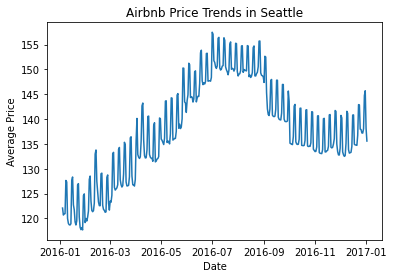

In [32]:
import matplotlib.pyplot as plt

dates = [row['date'] for row in price_trends_df.collect()]
avg_prices = [row['avg_price'] for row in price_trends_df.collect()]

plt.plot(dates, avg_prices)
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.title("Airbnb Price Trends in Seattle")
plt.show()

In [33]:
import pandas as pd

price_trends_pd = price_trends_df.toPandas()

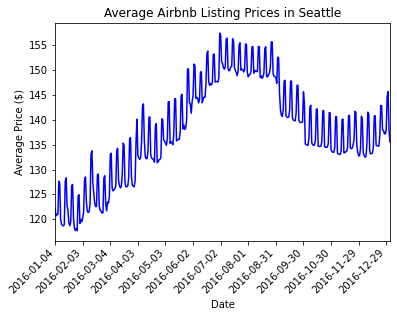

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# convert the PySpark dataframe to a Pandas dataframe
price_trends_pd = price_trends_df.toPandas()

# create a time series plot of the average price
plt.plot(price_trends_pd["date"], price_trends_pd["avg_price"], color="blue")

# set the x-axis limits and labels
plt.xlim(price_trends_pd["date"].min(), price_trends_pd["date"].max())
plt.xticks(rotation=45, ha="right")

# set the x-axis ticks and labels to show every 30 days
x_ticks = [i for i in range(0, len(price_trends_pd["date"]), 30)]
x_labels = price_trends_pd["date"][x_ticks]
plt.xticks(x_labels)

# add axis labels and a title
plt.xlabel("Date")
plt.ylabel("Average Price ($)")
plt.title("Average Airbnb Listing Prices in Seattle")

plt.show()


Seasson seems to be affecting the price trends quite a bit. let's try ARIMA (AutoRegressive Integrated Moving Average) model, to estimate seasonal trends and perhaps forecast future prices.

In [35]:
from statsmodels.tsa.arima.model import ARIMA

In [36]:
listings_df = listings.toPandas()

TypeError: ignored

In [37]:
listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [38]:
price_trends_pd['date'] = pd.to_datetime(price_trends_pd['date'])
price_trends_pd.set_index('date', inplace=True)


In [39]:
price_trends_pd['avg_price'] = pd.to_numeric(price_trends_pd['avg_price'], errors='coerce')


In [40]:
price_trends_pd.value_counts()

avg_price 
117.685413    1
143.457509    1
143.233837    1
143.225518    1
142.953637    1
             ..
133.788560    1
133.779055    1
133.689527    1
133.676934    1
157.480000    1
Length: 365, dtype: int64

In [41]:
model = ARIMA(price_trends_pd, order=(1, 1, 1))


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [42]:
model_fit = model.fit()


In [43]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              avg_price   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -949.370
Date:                Tue, 21 Mar 2023   AIC                           1904.740
Time:                        08:57:10   BIC                           1916.431
Sample:                    01-04-2016   HQIC                          1909.387
                         - 01-02-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4782      0.066     -7.234      0.000      -0.608      -0.349
ma.L1          0.9131      0.032     28.555      0.000       0.850       0.976
sigma2        10.7614      0.733     14.691      0.0

ARIMA seems to be a relatively good fit. ar of -0.47 indicates a negative corr between the current value and the previous.

ma is 0.91, a strong psotiive corr between the curr value and the previous error term. 

the p-values in the Ljung-box indicates no significant autocorr and the residuals are normally distributed.

In real life terms, the current price of an Airbnb rental in Seattle is influenced by the differene between the avg price of Airbnb rentals from the previous day and the average price from two days prior.



In [ ]:
model.fit()

AttributeError: ignored

In [44]:
forecast = model_fit.forecast(4)

In [45]:
forecast = pd.Series(forecast, index=pd.date_range(start='2016-04-01', periods=4, freq='MS'))


In [46]:
print(forecast)


2016-04-01   NaN
2016-05-01   NaN
2016-06-01   NaN
2016-07-01   NaN
Freq: MS, Name: predicted_mean, dtype: float64


<Axes: xlabel='date'>

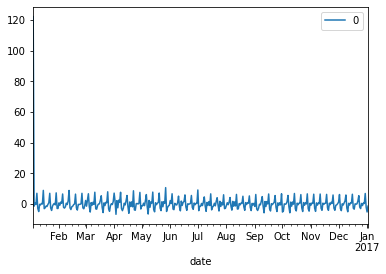

In [47]:
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
residuals.plot()

In [48]:
X = price_trends_pd.values

In [49]:
size = int(len(X)*0.66)

In [50]:
train, test = X[0:size], X[size:len(X)]


In [51]:
history = [x for x in train]


In [52]:
predictions = list()


In [53]:
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=148.070723, expected=148.536817
predicted=150.826542, expected=147.373164
predicted=152.235281, expected=152.636869
predicted=153.042012, expected=152.494845
predicted=149.878159, expected=145.329653
predicted=144.793841, expected=142.087264
predicted=146.209084, expected=140.924100
predicted=142.382018, expected=140.711215
predicted=145.068663, expected=142.007809
predicted=148.267173, expected=147.786994
predicted=148.920566, expected=147.973141
predicted=144.777343, expected=140.810043
predicted=139.075666, expected=140.558320
predicted=142.276776, expected=140.489105
predicted=139.474890, expected=140.584597
predicted=142.811208, expected=141.981719
predicted=146.674901, expected=147.830291
predicted=146.380054, expected=147.817300
predicted=143.712785, expected=140.380528
predicted=138.531329, expected=139.967442
predicted=141.865186, expected=139.862069
predicted=139.077694, expected=139.820820
predicted=142.380485, expected=141.204160
predicted=146.253421, expected=146

Test RMSE: 1.971


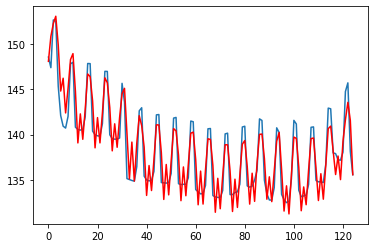

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=137.640682, expected=148.536817
predicted=146.466849, expected=147.373164
predicted=141.243495, expected=152.636869
predicted=152.916576, expected=152.494845
predicted=147.894176, expected=145.329653
predicted=135.481576, expected=142.087264
predicted=146.050630, expected=140.924100
predicted=142.459984, expected=140.711215
predicted=145.221231, expected=142.007809
predicted=147.950206, expected=147.786994
predicted=148.714014, expected=147.973141
predicted=144.836667, expected=140.810043
predicted=139.321754, expected=140.558320
predicted=142.119014, expected=140.489105
predicted=139.529335, expected=140.584597
predicted=143.042994, expected=141.981719
predicted=146.309048, expected=147.830291
predicted=146.269808, expected=147.817300
predicted=143.804388, expected=140.380528
predicted=138.780180, expected=139.967442
predicted=141.713494, expected=139.862069
predicted=139.133188, expected=139.820820
predicted=142.610110, expected=141.204160
predicted=145.908174, expected=146

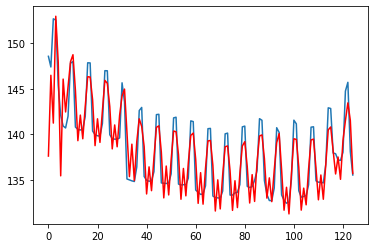

In [55]:
history = [x for x in test]
predictions = list()
residuals = list()
# walk-forward validation
for t in range(len(test)):
  model = ARIMA(history, order=(5,1,0))
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = test[t]
  residuals.append(obs - yhat)
  history.append(obs)
  
  print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [56]:
residuals

[array([10.8961352]),
 array([0.90631462]),
 array([11.39337432]),
 array([-0.42173111]),
 array([-2.56452313]),
 array([6.60568798]),
 array([-5.12652938]),
 array([-1.74876916]),
 array([-3.21342186]),
 array([-0.16321264]),
 array([-0.74087237]),
 array([-4.02662392]),
 array([1.23656597]),
 array([-1.62990869]),
 array([1.05526233]),
 array([-1.06127443]),
 array([1.52124351]),
 array([1.5474923]),
 array([-3.42386064]),
 array([1.18726186]),
 array([-1.85142525]),
 array([0.68763224]),
 array([-1.40594963]),
 array([1.06068432]),
 array([1.37077444]),
 array([-3.0704509]),
 array([1.10719787]),
 array([-1.55266927]),
 array([0.83884208]),
 array([-2.46483522]),
 array([1.42649733]),
 array([-1.39771078]),
 array([-5.07970558]),
 array([-0.35988847]),
 array([-4.00714291]),
 array([-0.10074182]),
 array([-2.7572834]),
 array([0.90136426]),
 array([2.07337617]),
 array([-3.28534375]),
 array([1.48277868]),
 array([-1.56741031]),
 array([1.06879704]),
 array([-1.52643636]),
 array([1

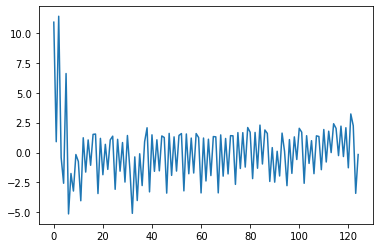

In [57]:
plt.plot(residuals)
plt.show()


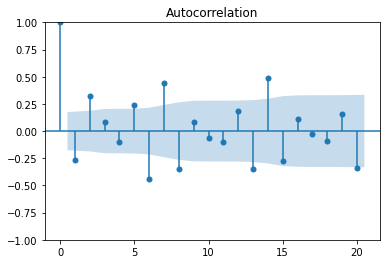

In [58]:
from statsmodels.graphics.tsaplots import plot_acf

residuals = [x[0] for x in residuals]  # convert your list of arrays to a list of values
plot_acf(residuals, lags=20)
plt.show()

In [59]:
listings.columns

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'weekly_price',


not significant autocorr.
perhaps an outlier in the first big jump



In [60]:
calendar_comb.columns

NameError: ignored

In [70]:
calendar_renamed = calendar_comb.select(col("listing_id").alias("id"), "start_date", 'end_date',"total_available", 'total_unavailable','total_days_opened',"price")


In [ ]:
reviews_renamed = reviews.select(col("listing_id").alias("id"), "date", "reviewer_id", "reviewer_name", "comments")


In [69]:
combined_df = listings.join(calendar_renamed, "id").join(reviews_renamed, ["id"], "left_outer")


NameError: ignored

In [62]:
combined_df.show()

NameError: ignored

In [ ]:
calendar.show()

+----------+----------+---------+-----+
|listing_id|      date|available|price|
+----------+----------+---------+-----+
|    241032|2016-01-04|        t| 85.0|
|    241032|2016-01-05|        t| 85.0|
|    241032|2016-01-06|        f| null|
|    241032|2016-01-07|        f| null|
|    241032|2016-01-08|        f| null|
|    241032|2016-01-09|        f| null|
|    241032|2016-01-10|        f| null|
|    241032|2016-01-11|        f| null|
|    241032|2016-01-12|        f| null|
|    241032|2016-01-13|        t| 85.0|
|    241032|2016-01-14|        t| 85.0|
|    241032|2016-01-15|        f| null|
|    241032|2016-01-16|        f| null|
|    241032|2016-01-17|        f| null|
|    241032|2016-01-18|        t| 85.0|
|    241032|2016-01-19|        t| 85.0|
|    241032|2016-01-20|        t| 85.0|
|    241032|2016-01-21|        f| null|
|    241032|2016-01-22|        f| null|
|    241032|2016-01-23|        f| null|
+----------+----------+---------+-----+
only showing top 20 rows



AttributeError: ignored

In [65]:
calendar.show()

+----------+-------------------+---------+-----+
|listing_id|               date|available|price|
+----------+-------------------+---------+-----+
|   3959442|2016-09-01 00:00:00|        t|150.0|
|   6425735|2017-01-01 00:00:00|        t| 99.0|
|   6426462|2016-11-13 00:00:00|        t| 65.0|
|   8104742|2016-02-04 00:00:00|        t|200.0|
|   5969872|2016-03-19 00:00:00|        t| 43.0|
|    654734|2016-12-12 00:00:00|        t|175.0|
|   1566487|2016-01-05 00:00:00|        t| 79.0|
|   7401854|2016-10-19 00:00:00|        t| 95.0|
|   9318440|2016-11-05 00:00:00|        t|200.0|
|    815017|2016-09-02 00:00:00|        t| 75.0|
|   7440415|2016-03-16 00:00:00|        t|180.0|
|   8814555|2016-12-11 00:00:00|        t| 88.0|
|    936484|2016-07-24 00:00:00|        t|309.0|
|    240920|2016-12-19 00:00:00|        t| 45.0|
|   7035240|2016-08-15 00:00:00|        t|300.0|
|   6916167|2016-11-28 00:00:00|        t|300.0|
|   4053092|2016-03-04 00:00:00|        t| 80.0|
|   8293287|2016-09-

In [63]:
from pyspark.sql.functions import first, last, count, when, col

calendar_comb = (calendar
                 .groupBy("listing_id")
                 .agg(first("date").alias("start_date"),
                      last("date").alias("end_date"),
                      count(when(col("available") == "t", True)).alias("total_available"),
                      count(when(col("available") == "f", True)).alias("total_unavailable"),
                      count('available').alias("total_days_opened"),
                      first("price", ignorenulls=True).alias("price"))
                )


In [64]:
calendar_comb.show()

+----------+-------------------+-------------------+---------------+-----------------+-----------------+-----+
|listing_id|         start_date|           end_date|total_available|total_unavailable|total_days_opened|price|
+----------+-------------------+-------------------+---------------+-----------------+-----------------+-----+
|   8034871|2016-12-18 00:00:00|2016-06-29 00:00:00|            350|               15|              365| 95.0|
|   1614502|2016-08-21 00:00:00|2016-03-27 00:00:00|            365|                0|              365| 75.0|
|   1251707|2016-06-17 00:00:00|2016-10-07 00:00:00|            365|                0|              365|236.0|
|   8379081|2016-04-15 00:00:00|2016-07-27 00:00:00|            228|              137|              365| 60.0|
|   4318031|2016-09-21 00:00:00|2016-12-05 00:00:00|             73|              292|              365| 77.0|
|   6658052|2016-08-14 00:00:00|2016-03-30 00:00:00|             29|              336|              365|116.0|
|

In [ ]:
from pyspark.sql.functions import isnan,when, count

calendar_comb.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in calendar_comb.columns]
   ).show()


+----------+----------+--------+---------------+-----------------+-----------------+-----+
|listing_id|start_date|end_date|total_available|total_unavailable|total_days_opened|price|
+----------+----------+--------+---------------+-----------------+-----------------+-----+
|         0|         0|       0|              0|                0|                0|   95|
+----------+----------+--------+---------------+-----------------+-----------------+-----+



In [66]:
calendar.filter(calendar.listing_id == 10015967).show()

+----------+-------------------+---------+-----+
|listing_id|               date|available|price|
+----------+-------------------+---------+-----+
|  10015967|2016-01-16 00:00:00|        f| null|
|  10015967|2016-05-07 00:00:00|        f| null|
|  10015967|2016-11-12 00:00:00|        f| null|
|  10015967|2016-11-22 00:00:00|        f| null|
|  10015967|2016-04-15 00:00:00|        f| null|
|  10015967|2016-01-26 00:00:00|        f| null|
|  10015967|2016-09-07 00:00:00|        f| null|
|  10015967|2016-02-18 00:00:00|        f| null|
|  10015967|2016-07-09 00:00:00|        f| null|
|  10015967|2016-07-20 00:00:00|        f| null|
|  10015967|2016-06-19 00:00:00|        f| null|
|  10015967|2016-02-04 00:00:00|        f| null|
|  10015967|2016-07-05 00:00:00|        f| null|
|  10015967|2016-11-29 00:00:00|        f| null|
|  10015967|2016-11-27 00:00:00|        f| null|
|  10015967|2016-10-23 00:00:00|        f| null|
|  10015967|2016-08-29 00:00:00|        f| null|
|  10015967|2016-05-

In [67]:
calendar_comb = calendar_comb.na.drop()

In [68]:
combined_df.count()

NameError: ignored

In [ ]:
combined_df = combined_df.repartition(15)


In [ ]:
combined_df.limit(1).count()

1

In [ ]:
num_partitions = combined_df.rdd.getNumPartitions()


In [ ]:
combined_df.limit(2).show()

+--------+--------------------+--------------+------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+--------------------+---------+----------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+-------------+----------------------+----------------------------+-------+-----+-------+-------+--------------+------------+-------------+-----------------+-------------------+-----------------+-------------+---------------+------------+---------+--------+----+--------+--------------------+--------------------+--------------

In [ ]:
combined_df.rdd.mapPartitionsWithIndex(lambda idx, it: [(idx, list(it))]).filter(lambda x: x[0] == 1).collect()

[(1,
  [Row(id='2026794', listing_url='https://www.airbnb.com/rooms/2026794', scrape_id='20160104002432', last_scraped='2016-01-04', name='Cozy charming 1905 cottage, W room', summary="Charming funky cottage in the heart of one of Seattle's best neighborhoods, Wallingford. While there is plenty of parking, you may not even need your car to enjoy what Seattle has to offer, as my 1905 home has a Walk Score of 91 and Bike Score of 85.", space="This is one of the original houses in the Wallingford neighborhood, built in 1905.  It was built at the very back of the lot (though in 1905 it was at the base of a small hill, now my neighbor's back yard), and subsequently has a big front yard and plenty of air space around the house.  Many of the houses in Wallingford are built quite close together, but my house has clear access to sunshine and garden views, particularly on the south side. The neighborhood used to be covered by an apple orchard, and we have one of the original trees, a Gravenstein

In [ ]:
reviews.show()

+----------+--------+----------+-----------+-------------+--------------------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|
+----------+--------+----------+-----------+-------------+--------------------+
|    176678| 5042747|2013-06-09|    6585682|        Jakob|Staying with Laur...|
|   6389657|39314524|2015-07-22|    1852794|         Anna|I had a long layo...|
|   3308825|40130369|2015-07-28|   13615443|     Kathleen|We had a wonderfu...|
|   1618842|51261474|2015-10-19|     349348|         Jean|The studio is eve...|
|    935845|13512921|2014-05-29|   14860397|        Clint|Wendy's apartment...|
|    797358|31500559|2015-05-05|     229056|          Dee|Awesome house! Gr...|
|     63733| 1983283|2012-08-14|    2432638|        Carla|Very cute, cozy p...|
|   1707064|18497790|2014-08-27|   19956826|         Erin|Cory and Amanda w...|
|    158345| 4067973|2013-04-07|    5591022|       Mariah|Marcia is the bes...|
|   1539476|52340775|2015-10-28|   11966

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
reviews = review


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# load the stop words
stop_words = set(stopwords.words('english'))

# define the preprocessing function
def preprocess(comment):
    if comment is None:
        return []
    # convert to lowercase
    comment = comment.lower()
    # remove punctuations
    comment = comment.translate(str.maketrans('', '', string.punctuation))
    # tokenize the comment
    words = word_tokenize(comment)
    # remove stop words
    words = [word for word in words if word not in stop_words]
    return words

# define the UDF to apply the preprocessing function to the comments column
preprocess_udf = udf(preprocess, ArrayType(StringType()))

# apply the preprocessing UDF to the comments column
reviews = reviews.withColumn('words', preprocess_udf(reviews.comments))

# explode the words column to create a new row for each word
reviews = reviews.selectExpr('listing_id', 'explode(words) as word')

# group by the word column and count the frequency of each word
word_counts = reviews.groupBy('word').count()

# get the top 10 most frequent words
top_words = word_counts.orderBy('count', ascending=False).limit(10)

# show the top 10 most frequent words
top_words.show()


+-----------+-----+
|       word|count|
+-----------+-----+
|      great|53310|
|       stay|43823|
|      place|38785|
|    seattle|32318|
|         us|26548|
|      clean|25609|
|   location|25058|
|  apartment|21916|
|comfortable|21640|
|      would|20159|
+-----------+-----+



In [ ]:
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer

In [ ]:
reviews = reviews.fillna({'comments': ''})

In [ ]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = 'comments', outputCol = 'words')

In [ ]:
from pyspark.ml.feature import StopWordsRemover

stopword_remover = StopWordsRemover(inputCol = 'words', outputCol = 'filtered_words')

In [ ]:
vectorizer = CountVectorizer(inputCol = 'filtered_words', outputCol = 'features')

In [ ]:
from pyspark.ml import Pipeline

pipeline_model = Pipeline(stages=[tokenizer, stopword_remover, vectorizer])

In [ ]:
preprocessed_df = pipeline.fit(reviews).transform(reviews).select('listing_id','features')

In [ ]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter = max_iterations)
lda_model = lda.fit(preprocessed_df)

In [ ]:
vocab = pipeline.stages[-1].vocabulary
for i, topic in enumerate(topics):
    print("Topic {}: ".format(i))
    for word_idx in topic[0]:
        print("    {}".format(vocab[word_idx]))

TypeError: ignored

In [ ]:
from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover
from pyspark.ml.clustering import LDA

# Tokenize comments
tokenizer = Tokenizer(inputCol="comments", outputCol="tokens")
tokens_df = tokenizer.transform(reviews)

# Remove stop words
sw_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
filtered_tokens_df = sw_remover.transform(tokens_df)

# Create count vectorizer
cv = CountVectorizer(inputCol="filtered_tokens", outputCol="features")
cv_model = cv.fit(filtered_tokens_df)
vectorized = cv_model.transform(filtered_tokens_df)

# Fit LDA model
lda = LDA(k=5, maxIter=10)
lda_model = lda.fit(vectorized)

# Get vocabulary from count vectorizer model
vocabulary = cv_model.vocabulary

# Get top words for each topic
topics = lda_model.describeTopics(maxTermsPerTopic=10)
for topic in topics.collect():
    print("Topic {}: ".format(topic[0]))
    for word_idx in topic[1]:
        print("    {}".format(vocabulary[word_idx]))


Topic 0: 
    
    great
    stay
    place
    us
    apartment
    location
    nice
    everything
    seattle
Topic 1: 
    
    great
    place
    house
    stay
    apartment
    us
    really
    recommend
    location
Topic 2: 
    great
    
    us
    stay
    place
    really
    room
    comfortable
    location
    made
Topic 3: 
    great
    place
    stay
    
    de
    und
    seattle
    location
    room
    la
Topic 4: 
    stay
    place
    great
    us
    
    definitely
    everything
    recommend
    room
    perfect


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob

# Define a UDF to get the sentiment score for each comment
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment > 0:
        return "positive"
    elif sentiment < 0:
        return "negative"
    else:
        return "neutral"

# Register the UDF
sentiment_udf = udf(get_sentiment, StringType())

# Apply the UDF to the comments column and create a new sentiment column
reviews = reviews.withColumn("sentiment", sentiment_udf("comments"))


In [ ]:
reviews.show()

+----------+--------+----------+-----------+-------------+--------------------+---------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|sentiment|
+----------+--------+----------+-----------+-------------+--------------------+---------+
|    176678| 5042747|2013-06-09|    6585682|        Jakob|Staying with Laur...| positive|
|   6389657|39314524|2015-07-22|    1852794|         Anna|I had a long layo...| positive|
|   3308825|40130369|2015-07-28|   13615443|     Kathleen|We had a wonderfu...| positive|
|   1618842|51261474|2015-10-19|     349348|         Jean|The studio is eve...| positive|
|    935845|13512921|2014-05-29|   14860397|        Clint|Wendy's apartment...| positive|
|    797358|31500559|2015-05-05|     229056|          Dee|Awesome house! Gr...| positive|
|     63733| 1983283|2012-08-14|    2432638|        Carla|Very cute, cozy p...| positive|
|   1707064|18497790|2014-08-27|   19956826|         Erin|Cory and Amanda w...| positive|
|    15834

In [ ]:
# Define a UDF to get the sentiment score for each comment
def get_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    return sentiment
# Register the UDF
sentiment_udf = udf(get_sentiment, StringType())

# Apply the UDF to the comments column and create a new sentiment column
reviews = reviews.withColumn("sentiment_val", sentiment_udf("comments"))

In [ ]:
reviews.show()

+----------+--------+----------+-----------+-------------+--------------------+---------+-------------------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|sentiment|      sentiment_val|
+----------+--------+----------+-----------+-------------+--------------------+---------+-------------------+
|    176678| 5042747|2013-06-09|    6585682|        Jakob|Staying with Laur...| positive| 0.2888888888888889|
|   6389657|39314524|2015-07-22|    1852794|         Anna|I had a long layo...| positive|0.20280303030303026|
|   3308825|40130369|2015-07-28|   13615443|     Kathleen|We had a wonderfu...| positive| 0.6514285714285715|
|   1618842|51261474|2015-10-19|     349348|         Jean|The studio is eve...| positive| 0.2955957300275482|
|    935845|13512921|2014-05-29|   14860397|        Clint|Wendy's apartment...| positive| 0.2553333333333333|
|    797358|31500559|2015-05-05|     229056|          Dee|Awesome house! Gr...| positive|               0.74|
|     6373